In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import zipfile
from pathlib import Path

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
# Check CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## **Data Collection and Loading**

We load the 64×64 RGB cat face images from disk, resize them if needed, and store them in a NumPy array.  
Basic info (count, shape, value range) is displayed to confirm that the dataset is properly loaded.

In [ ]:
# Dataset URL from Kaggle (direct download)
# Note: You may need to download manually from:
# https://www.kaggle.com/datasets/spandan2/cats-faces-64x64-for-generative-models

# For this exercise, we'll assume you have downloaded and extracted the dataset
data_dir = '../data/cats_dataset'  # Update this path to your dataset location


# If you have the dataset as a zip file, uncomment to extract:
with zipfile.ZipFile('../data/archive.zip', 'r') as zip_ref:
    zip_ref.extractall("../data")

print(f"Dataset directory: {data_dir}")

Dataset directory: ../data/cats_dataset


In [ ]:
def load_cat_images(data_dir, max_images=None):
    """
    Load cat face images from directory
    Returns: numpy array of shape (n_samples, 64, 64, 3)
    """
    image_files = list(Path(data_dir).glob('*.jpg')) + list(Path(data_dir).glob('*.png'))
    
    if max_images:
        image_files = image_files[:max_images]
    
    images = []
    for img_path in image_files:
        img = Image.open(img_path).convert('RGB')
        img = img.resize((64, 64))  # Ensure 64x64
        images.append(np.array(img))
    
    return np.array(images)


In [ ]:
data_dir="../data/cats"
# Load images
images = load_cat_images(data_dir)
print(f"Loaded {len(images)} images")
print(f"Image shape: {images[1].shape}")
print(f"Data type: {images.dtype}")
print(f"Value range: [{images.min()}, {images.max()}]")

Loaded 15747 images
Image shape: (64, 64, 3)
Data type: uint8
Value range: [0, 255]


## **Data Visualization**

Below we display a few sample images from the dataset to verify that the data has been loaded correctly and to get a quick sense of the visual content we will train the model on.


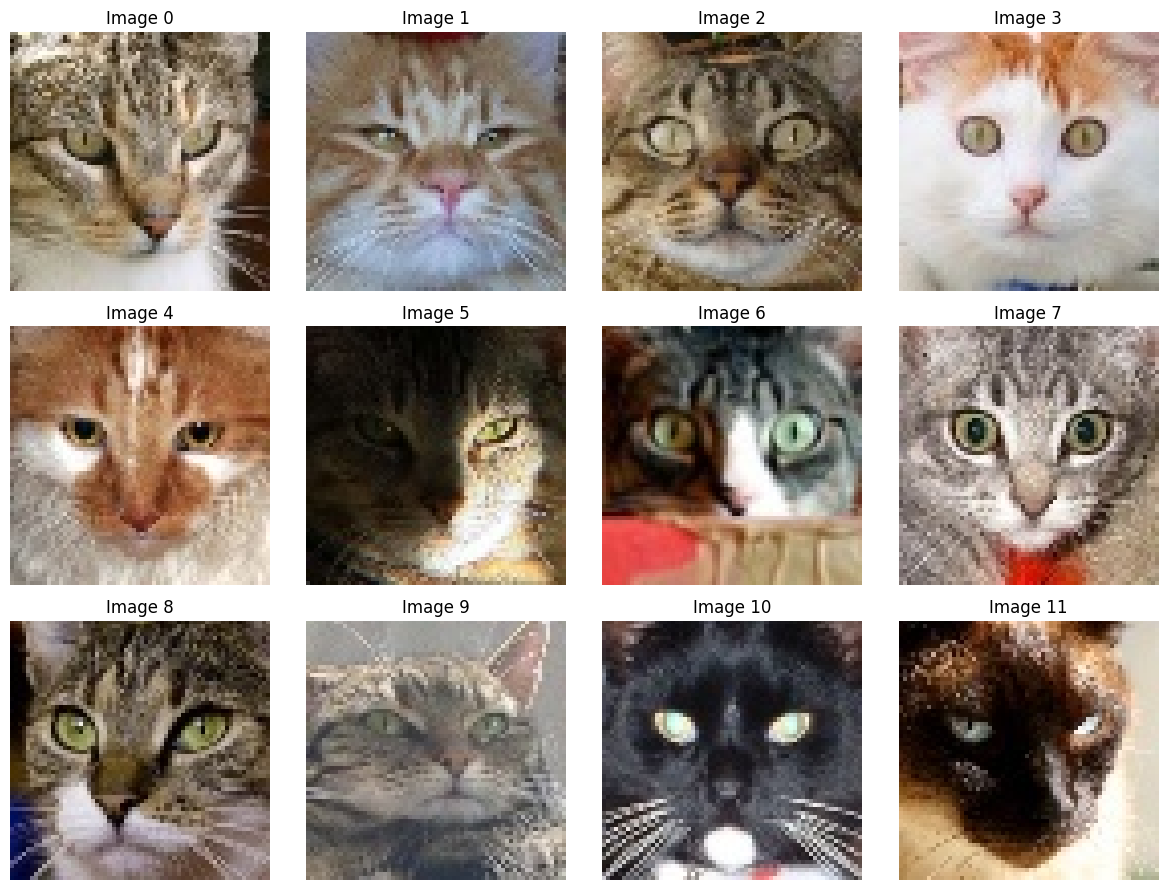

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(12, 9))
axes = axes.flatten()

for i in range(12):
    axes[i].imshow(images[i])
    axes[i].axis('off')
    axes[i].set_title(f'Image {i}')

plt.tight_layout()
plt.show()

## **Data Preparation**



In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

#Preprocessing for diffusion model

images_normalized = (images.astype('float32') - 127.5) / 127.5

images_normalized = images_normalized.transpose(0,3,1,2)
print(f"Normalized shape: {images_normalized.shape}")
print(f"Normalized range: [{images_normalized.min():.3f}, {images_normalized.max():.3f}]")

# Split into train/validation sets
split_idx = int(0.9 * len(images_normalized))
train_images = images_normalized[:split_idx]
val_images = images_normalized[split_idx:]

print(f"\nTraining samples: {len(train_images)}")
print(f"Validation samples: {len(val_images)}")



train_images_tensor=torch.tensor(train_images).to(torch.float32)
val_images_tensor=torch.tensor(val_images).to(torch.float32)

train_dataset=TensorDataset(train_images_tensor)
val_dataset=TensorDataset(val_images_tensor)

batch_size=64

train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
val_loader=DataLoader(val_dataset, batch_size=batch_size,shuffle=True)

Normalized shape: (15747, 3, 64, 64)
Normalized range: [-1.000, 1.000]

Training samples: 14172
Validation samples: 1575


In [ ]:
model = SimpleUNet(img_channels=3, base_channels=64, time_dim=128).to(device)



In [ ]:
import torch.nn.functional as F

def train_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0

    for batch in loader:
        x0 = batch[0].to(device)          # (B,3,64,64) dans [-1,1]
        B = x0.size(0)

        # échantillonner t uniformément entre 0 et T-1
        t = torch.randint(0, T, (B,), device=device)

        # bruit cible
        noise = torch.randn_like(x0)

        # x_t = q(x_t | x0, t)
        x_t, noise = q_sample(x0, t, noise)

        # prédiction epsilon_theta(x_t, t)
        eps_pred = model(x_t, t)

        # loss = MSE entre bruit prédit et bruit réel
        loss = F.mse_loss(eps_pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


def evaluate(model, loader, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch in loader:
            x0 = batch[0].to(device)
            B = x0.size(0)

            t = torch.randint(0, T, (B,), device=device)
            noise = torch.randn_like(x0)
            x_t, noise = q_sample(x0, t, noise)
            eps_pred = model(x_t, t)

            loss = F.mse_loss(eps_pred, noise)
            total_loss += loss.item()

    return total_loss / len(loader)


def train_model(model, train_loader, val_loader, device, epochs=20, lr=2e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(epochs):
        train_loss = train_epoch(model, train_loader, optimizer, device)
        val_loss = evaluate(model, val_loader, device)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)

        print(f"Epoch {epoch+1}/{epochs}  "
              f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    return history

def plot_training_history(history, title="Training History"):
    plt.figure(figsize=(6,4))
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()



In [ ]:
model = SimpleUNet().to(device)
history = train_model(model, train_loader, val_loader, device, epochs=20, lr=2e-4)
plot_training_history(history, title="Diffusion Training (eps-prediction)")

RuntimeError: Given groups=1, weight of size [128, 256, 3, 3], expected input[64, 384, 32, 32] to have 256 channels, but got 384 channels instead

In [ ]:
# Pour le sampling
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)             # 1 / sqrt(alpha_t)
sqrt_one_minus_alpha_bars = torch.sqrt(1.0 - alpha_bars) # déjà calculé si tu veux

In [ ]:
@torch.no_grad()
def p_sample(model, x_t, t):
    """
    x_t : (B, 3, 64, 64)
    t   : (B,) indices de temps (même t pour tout le batch ici)
    """
    # On suppose que t est un entier scalaire ou bien un tensor rempli de la même valeur
    betas_t = betas[t].view(-1, 1, 1, 1)                      # (B,1,1,1)
    sqrt_one_minus_ab_t = sqrt_one_minus_alpha_bars[t].view(-1, 1, 1, 1)
    sqrt_recip_alpha_t = sqrt_recip_alphas[t].view(-1, 1, 1, 1)

    # Bruit prédit par le réseau
    eps_theta = model(x_t, t)                                 # (B,3,64,64)

    # Moyenne de la gaussienne p_theta(x_{t-1} | x_t)
    model_mean = sqrt_recip_alpha_t * (
        x_t - (betas_t / sqrt_one_minus_ab_t) * eps_theta
    )

    # À t=0, on ne rajoute plus de bruit
    if t[0] == 0:
        return model_mean

    # Sinon on rajoute un petit bruit gaussien
    noise = torch.randn_like(x_t)
    sigma_t = torch.sqrt(betas_t)
    return model_mean + sigma_t * noise

In [ ]:
@torch.no_grad()
def sample(model, n_samples, device):
    model.eval()
    # On démarre de pur bruit
    x_t = torch.randn(n_samples, 3, 64, 64, device=device)

    # t = T-1, ..., 0
    for t_step in reversed(range(T)):
        t = torch.full((n_samples,), t_step, device=device, dtype=torch.long)
        x_t = p_sample(model, x_t, t)

    return x_t

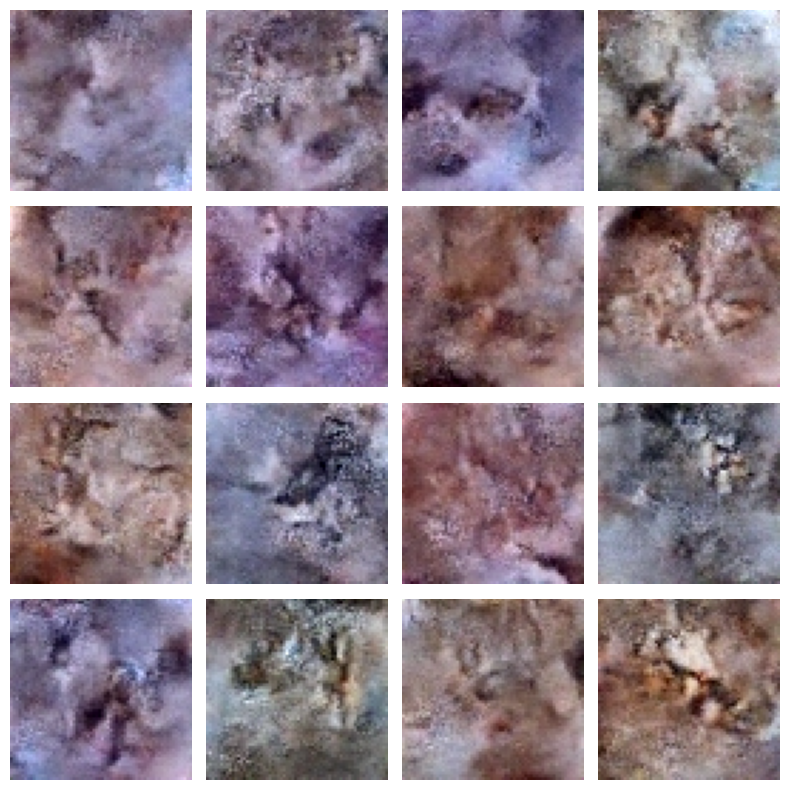

In [ ]:
# Génération
n_samples = 16
samples = sample(model, n_samples, device).cpu()

# Remettre en [0,1] pour affichage (images étaient en [-1,1])
samples = (samples.clamp(-1, 1) + 1) / 2

# Affichage en grille
import matplotlib.pyplot as plt
import numpy as np

rows, cols = 4, 4
fig, axes = plt.subplots(rows, cols, figsize=(2*cols, 2*rows))

for i in range(rows * cols):
    ax = axes[i // cols, i % cols]
    img = samples[i].permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    ax.axis("off")

plt.tight_layout()
plt.show()

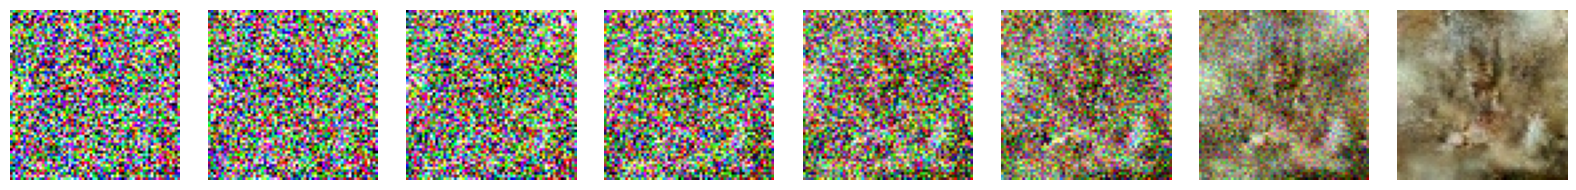

In [ ]:
@torch.no_grad()
def sample_trajectory(model, device, n_steps_to_show=8):
    model.eval()
    x_t = torch.randn(1, 3, 64, 64, device=device)
    images = []

    steps = np.linspace(0, T-1, n_steps_to_show, dtype=int)[::-1]

    for t_step in reversed(range(T)):
        t = torch.full((1,), t_step, device=device, dtype=torch.long)
        x_t = p_sample(model, x_t, t)
        if t_step in steps:
            images.append(x_t.detach().cpu())

    return images

images = sample_trajectory(model, device, n_steps_to_show=8)
images = [(img.clamp(-1,1) + 1)/2 for img in images]

fig, axes = plt.subplots(1, len(images), figsize=(2*len(images), 2))
for i, img in enumerate(images):
    ax = axes[i]
    ax.imshow(img[0].permute(1, 2, 0).numpy())
    ax.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
# Nombre d'étapes de diffusion
T = 300

# 2) Beta schedule (tensor de taille T)
betas = torch.linspace(1e-4, 0.02,T,device=device)

# 3) Alphas
alphas = 1 - betas

# 4) Produit cumulatif des alphas
alpha_bars = torch.cumprod(alphas,dim=0).to(device)

# 5) Pré-calculer les racines
sqrt_alpha_bars = torch.sqrt(alpha_bars).to(device)
sqrt_one_minus_alpha_bars = torch.sqrt(1-alpha_bars).to(device)

In [ ]:
print(betas.shape, alphas.shape, alpha_bars.shape)
print(sqrt_alpha_bars[:5], sqrt_one_minus_alpha_bars[:5])

torch.Size([300]) torch.Size([300]) torch.Size([300])
tensor([0.9999, 0.9999, 0.9998, 0.9996, 0.9994]) tensor([0.0100, 0.0163, 0.0224, 0.0283, 0.0341])


In [ ]:
def q_sample(x0, t, noise=None):
    """
    x0 : batch d'images (B, 3, 64, 64)
    t  : instants (B,)
    """

    if noise is None:
        noise = torch.randn_like(x0)

    # coeffs : (B,) -> (B,1,1,1)
    sqrt_alpha_bar_t = sqrt_alpha_bars[t].view(-1, 1, 1, 1)
    sqrt_one_minus_alpha_bar_t = sqrt_one_minus_alpha_bars[t].view(-1, 1, 1, 1)

    x_t = sqrt_alpha_bar_t * x0 + sqrt_one_minus_alpha_bar_t * noise

    return x_t, noise

In [ ]:
# un batch aléatoire
x0 = torch.randn(8, 3, 64, 64).to(device)

# Tirer 8 timestamps aléatoires
t = torch.randint(0, T, (8,), device=device)

# Forward process
x_t, noise = q_sample(x0, t)

print("x_t shape:", x_t.shape)
print("noise shape:", noise.shape)
print("t:", t)
print("alpha_bar[t]:", alpha_bars[t])

x_t shape: torch.Size([8, 3, 64, 64])
noise shape: torch.Size([8, 3, 64, 64])
t: tensor([144,  55, 131, 231, 207, 179, 175,  83])
alpha_bar[t]: tensor([0.4908, 0.8974, 0.5541, 0.1627, 0.2321, 0.3347, 0.3511, 0.7859])


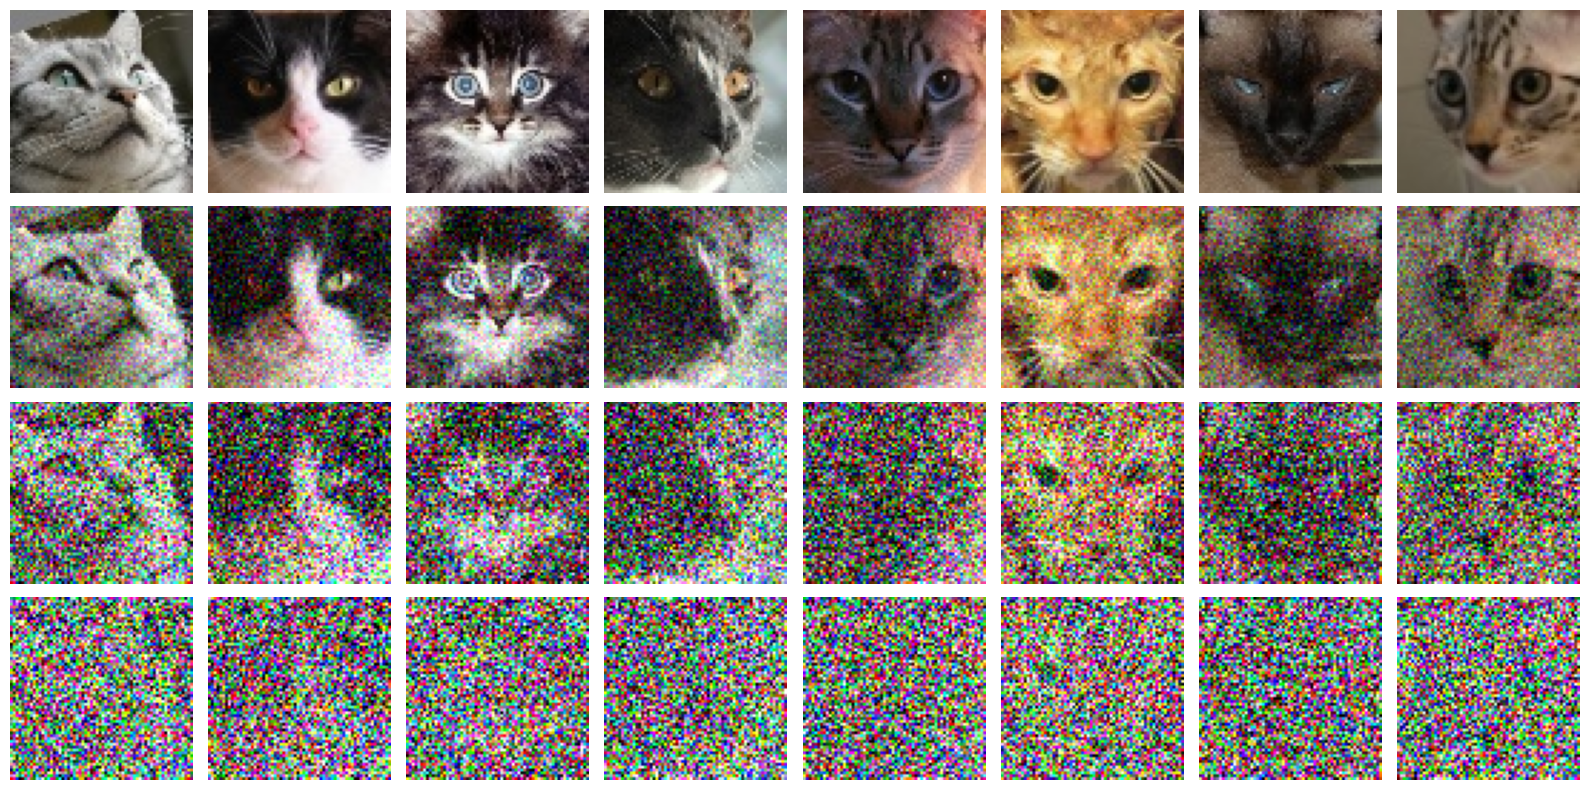

In [ ]:
batch = next(iter(train_loader))  # récupère le premier batch
x0 = batch[0][:8].to(device)         
t=[0, 50, 150, 299]

xs = [x0]  # t = 0
for t_scalar in t[1:]:
    # t_tensor = (B,) rempli avec t_scalar
    t_tensor = torch.full((x0.size(0),), t_scalar, dtype=torch.long, device=device)
    x_t, _ = q_sample(x0, t_tensor, noise=noise)
    xs.append(x_t)

def to_numpy_img_batch(x):
    # [-1,1] -> [0,1]
    x = (x + 1) / 2
    x = torch.clamp(x, 0, 1)
    # (B,3,64,64) -> (B,64,64,3)
    return x.permute(0, 2, 3, 1).cpu().numpy()

num_rows = len(xs)           # 4 (t=0,50,150,299)
num_cols = x0.size(0)        # 8 images

fig, axes = plt.subplots(num_rows, num_cols, figsize=(2*num_cols, 2*num_rows))

row_titles = ["x0 (t=0)", "t=50", "t=150", "t=299"]

for row in range(num_rows):
    imgs = to_numpy_img_batch(xs[row])   # (B,64,64,3)
    for col in range(num_cols):
        ax = axes[row, col]
        ax.imshow(imgs[col])
        ax.axis("off")
        if col == 0:
            ax.set_ylabel(row_titles[row], fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
import torch
import torch.nn as nn
import math

class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        """
        t : (B,) timestamps (int ou float)
        return : (B, dim)
        """
        device = t.device
        half_dim = self.dim // 2

        # fréquences
        freqs = torch.exp(
            -torch.linspace(0, math.log(10000), half_dim, device=device)
        )

        # (B, half_dim)
        # Si t est int64, on le cast en float
        t = t.float()
        args = t[:, None] * freqs[None, :]

        # concat sin et cos → (B, dim)
        emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
        return emb

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_dim=None):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.norm1 = nn.GroupNorm(num_groups=8, num_channels=out_channels)
        self.act1 = nn.SiLU()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.norm2 = nn.GroupNorm(num_groups=8, num_channels=out_channels)
        self.act2 = nn.SiLU()

        # Si on veut injecter le temps, on rajoute un petit MLP qui projette t_emb -> out_channels
        if time_dim is not None:
            self.time_mlp = nn.Linear(time_dim, out_channels)
        else:
            self.time_mlp = None

    def forward(self, x, t_emb=None):
        """
        x : (B, C, H, W)
        t_emb : (B, time_dim) ou None
        """
        h = self.conv1(x)

        if self.time_mlp is not None and t_emb is not None:
            # t_emb : (B, time_dim) -> (B, out_channels)
            temb = self.time_mlp(t_emb)          # (B, out_channels)
            temb = temb[:, :, None, None]        # (B, out_channels, 1, 1)
            h = h + temb                         # broadcast sur H, W

        h = self.act1(self.norm1(h))
        h = self.act2(self.norm2(self.conv2(h)))
        return h


class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_dim=None):
        super().__init__()
        self.block = ConvBlock(in_channels, out_channels, time_dim=time_dim)
        self.down = nn.Conv2d(out_channels, out_channels, kernel_size=4, stride=2, padding=1)

    def forward(self, x, t_emb=None):
        """
        x : (B, C, H, W)
        t_emb : (B, time_dim)
        """
        h = self.block(x, t_emb)   # même résolution
        x_down = self.down(h)      # résolution /2
        return x_down, h           # x_down pour continuer, h pour le skip


class UpBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels, time_dim=None):
        super().__init__()

        # upsample : (H, W) -> (2H, 2W)
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)

        # Après concat : channels = out_c + skip_c
        self.block = ConvBlock(out_channels + skip_channels, out_channels, time_dim=time_dim)

    def forward(self, x, skip, t_emb=None):
        """
        x    : (B, C_in, H, W)       (plus petite résolution)
        skip : (B, C_skip, 2H, 2W)   (résolution plus grande)
        t_emb : (B, time_dim)
        """
        x = self.up(x)                       # (B, out_c, 2H, 2W)
        x = torch.cat([x, skip], dim=1)      # concat sur les canaux
        x = self.block(x, t_emb)
        return x



In [ ]:
class SimpleUNet(nn.Module):
    def __init__(self, img_channels=3, base_channels=32, time_dim=128):
        super().__init__()

        self.time_dim = time_dim

        # Embedding temporel + MLP
        self.time_mlp = nn.Sequential(
            SinusoidalTimeEmbedding(time_dim),
            nn.Linear(time_dim, time_dim),
            nn.SiLU(),
            nn.Linear(time_dim, time_dim),
        )

        # Down : 64x64 -> 32x32 -> 16x16
        self.down1 = DownBlock(img_channels,        base_channels,      time_dim=time_dim)       # 3 -> 64
        self.down2 = DownBlock(base_channels,       base_channels * 2,  time_dim=time_dim)       # 64 -> 128

        # Bottleneck à 16x16
        self.bottleneck = ConvBlock(base_channels * 2, base_channels * 2, time_dim=time_dim)     # 128 -> 128

        # Up : 16x16 -> 32x32 -> 64x64
        self.up2 = UpBlock(base_channels * 2, base_channels * 2, base_channels,     time_dim=time_dim)  # 128 + 128 -> 64
        self.up1 = UpBlock(base_channels,     base_channels,     base_channels,     time_dim=time_dim)  # 64 + 64   -> 64

        # Projection finale vers 3 canaux (bruit prédit sur l'image)
        self.out_conv = nn.Conv2d(base_channels, img_channels, kernel_size=1)

    def forward(self, x, t):
        """
        x : (B, 3, 64, 64)  -> x_t (image bruitée)
        t : (B,)            -> timestep pour chaque image du batch
        """
        # Embedding temporel : (B, time_dim)
        t_emb = self.time_mlp(t)

        # Chemin descendant
        x1_down, h1 = self.down1(x, t_emb)         # h1 : skip pour 64x64
        x2_down, h2 = self.down2(x1_down, t_emb)   # h2 : skip pour 32x32

        # Bottleneck
        b = self.bottleneck(x2_down, t_emb)        # 16x16

        # Chemin ascendant
        x = self.up2(b, h2, t_emb)                 # 16->32
        x = self.up1(x, h1, t_emb)                 # 32->64

        # Sortie
        out = self.out_conv(x)                     # (B, 3, 64, 64)
        return out

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

# -------------------------
# 1. Embedding temporel
# -------------------------

class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        """
        t : (B,) entiers
        return : (B, dim)
        """
        device = t.device
        half_dim = self.dim // 2

        freqs = torch.exp(
            torch.linspace(0, math.log(10000), half_dim, device=device) * -1
        )

        args = t[:, None].float() * freqs[None, :]      # (B, half_dim)
        emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)  # (B, dim)
        return emb


# -------------------------
# 2. Bloc résiduel avec temps
# -------------------------

class ResBlock(nn.Module):
    def __init__(self, in_c, out_c, time_dim):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.gn1   = nn.GroupNorm(num_groups=8, num_channels=out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.gn2   = nn.GroupNorm(num_groups=8, num_channels=out_c)

        # projette l'embedding temporel vers out_c
        self.time_mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_dim, out_c)
        )

        # shortcut si in_c != out_c
        if in_c != out_c:
            self.shortcut = nn.Conv2d(in_c, out_c, kernel_size=1)
        else:
            self.shortcut = nn.Identity()

    def forward(self, x, t_emb):
        """
        x    : (B, C, H, W)
        t_emb: (B, time_dim)
        """
        h = self.conv1(x)
        h = self.gn1(h)
        h = F.silu(h)

        # ajoute le temps
        t_out = self.time_mlp(t_emb)          # (B, out_c)
        t_out = t_out[:, :, None, None]       # (B, out_c, 1, 1)
        h = h + t_out

        h = self.conv2(h)
        h = self.gn2(h)
        h = F.silu(h)

        return h + self.shortcut(x)


# -------------------------
# 3. Blocs Down / Up
# -------------------------

class DownBlock(nn.Module):
    def __init__(self, in_c, out_c, time_dim):
        super().__init__()
        self.res = ResBlock(in_c, out_c, time_dim)
        self.down = nn.Conv2d(out_c, out_c, kernel_size=4, stride=2, padding=1)

    def forward(self, x, t_emb):
        h = self.res(x, t_emb)       # (B, out_c, H, W)
        x_down = self.down(h)        # (B, out_c, H/2, W/2)
        return x_down, h             # on renvoie aussi le skip


class UpBlock(nn.Module):
    def __init__(self, in_c, skip_c, out_c, time_dim):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=4, stride=2, padding=1)
        # après upsample : out_c canaux, qu’on concatène avec skip_c → out_c + skip_c
        self.res = ResBlock(out_c + skip_c, out_c, time_dim)

    def forward(self, x, skip, t_emb):
        x = self.up(x)                     # (B, out_c, 2H, 2W)
        x = torch.cat([x, skip], dim=1)    # (B, out_c + skip_c, 2H, 2W)
        x = self.res(x, t_emb)             # (B, out_c, 2H, 2W)
        return x


# -------------------------
# 4. UNet complet pour diffusion
# -------------------------

class SimpleUNet(nn.Module):
    def __init__(self, time_dim=128):
        super().__init__()
        self.time_dim = time_dim

        # embedding temporel
        self.time_embed = nn.Sequential(
            SinusoidalTimeEmbedding(time_dim),
            nn.Linear(time_dim, time_dim),
            nn.SiLU(),
            nn.Linear(time_dim, time_dim)
        )

        # plan de canaux : 3 -> 64 -> 128 -> 256 -> 128 -> 64 -> 3
        self.down1 = DownBlock(3,   64,  time_dim)   # 64x64 -> 32x32
        self.down2 = DownBlock(64,  128, time_dim)   # 32x32 -> 16x16

        self.bottleneck = ResBlock(128, 256, time_dim)  # 16x16

        self.up2 = UpBlock(256, 128, 128, time_dim)  # 16x16 -> 32x32
        self.up1 = UpBlock(128, 64,   64,  time_dim)  # 32x32 -> 64x64

        self.out_conv = nn.Conv2d(64, 3, kernel_size=1)

    def forward(self, x, t):
        """
        x : (B, 3, 64, 64)  = x_t bruitées
        t : (B,)            = timestamps
        retourne : epsilon_theta(x_t, t) même shape que x
        """
        t_emb = self.time_embed(t)     # (B, time_dim)

        # encoder
        x1, h1 = self.down1(x, t_emb)  # x1: (B, 64, 32,32), h1 pour skip
        x2, h2 = self.down2(x1, t_emb) # x2: (B,128,16,16), h2 pour skip

        # bottleneck
        b = self.bottleneck(x2, t_emb) # (B,256,16,16)

        # decoder
        x = self.up2(b,  h2, t_emb)    # (B,128,32,32)
        x = self.up1(x, h1, t_emb)     # (B, 64,64,64)

        out = self.out_conv(x)         # (B, 3, 64,64)
        return out

In [ ]:
model = SimpleUNet().to(device)
history = train_model(model, train_loader, val_loader, device, epochs=20, lr=2e-4)
plot_training_history(history, title="Diffusion Training (eps-prediction)")

Epoch 1/20  Train Loss: 0.1413 | Val Loss: 0.0786
Epoch 2/20  Train Loss: 0.0756 | Val Loss: 0.0668
Epoch 3/20  Train Loss: 0.0671 | Val Loss: 0.0694
Epoch 4/20  Train Loss: 0.0648 | Val Loss: 0.0656
Epoch 5/20  Train Loss: 0.0616 | Val Loss: 0.0626
Epoch 6/20  Train Loss: 0.0611 | Val Loss: 0.0600
